In [ ]:
#@title
import pandas as pd
import re
import os
import time
import random
import numpy as np

try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from google.colab import drive
import pickle

import spacy

nlp = spacy.load("en_core_web_sm")
from nltk.translate.bleu_score import corpus_bleu

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
tf.__version__

'2.5.0'

In [ ]:
# # Mount drive
# drive.mount('/gdrive')
# drive_root = '/gdrive/My Drive/'

In [ ]:
import pandas as pd
df = pd.read_json("\Path to dataset")


In [ ]:
df.shape

(15999, 4)

In [ ]:
df.head()

,Figure,Question,Answer,Equation
0,Geo_Figures\plotcirclesar0.png,If radius of this figure is 0.45 units. What i...,0.64,X=3.14*0.45*0.45
1,Geo_Figures\plotrectanglesar0.png,If length of this figure is 37.17 units and wi...,2440.58,X=37.17*65.66
2,Geo_Figures\plotlines0.png,"If coordinates of this figure are (2.29 , 4.63...",-0.03,X=(4.67-4.63)/(0.73-2.29)
3,Geo_Figures\plottrianglear0.png,"If the three sides of this figure are [(6.12, ...",13.72,X=(0.5*((6.12*(9.92-6.21))+(1.89*(6.21-1.24))+...
4,Geo_Figures\plotsquarear0.png,Length of a side of a of this figure is 7.07 u...,49.98,X=7.07*7.07


In [ ]:
def convert_eqn(eqn):
  '''
  Add a space between every character in the equation string.
  Eg: 'x = 23 + 88' becomes 'x =  2 3 + 8 8'
  '''
  elements = list(eqn)
  return ' '.join(elements)

In [ ]:
input_exps = list(df['Question'].values)

In [ ]:
target_exps = list(df['Equation'].apply(lambda x: convert_eqn(x)).values)

In [ ]:
fig_exps = list(df['Figure'].values)

In [ ]:
Memory = {}
Memory['Fact1'] = 'Area of Circle = pi * radius * radius'
Memory['Fact2'] = 'Circumference of Circle = 2*pi*radius'
Memory['Fact3'] = 'Area of Rectangle = length * width'
Memory['Fact4'] = 'Perimeter of Rectangle = 2*(length + width)'
Memory['Fact5'] = 'Slope of line = (y2-y1)/(x2-x1)'
Memory['Fact6'] = 'Area of Triangle = (0.5*((x0*(y1-y2))+(x1*(y2-y0))+(x2*(y0-y1))'
Memory['Fact7'] = 'Perimeter of Triangle = side1 + side2 + side3'
Memory['Fact8'] = 'Minimum height of Triangle = (2*area)/base'
Memory['Fact9'] = 'Area of Square = side * side'
Memory['Fact10'] = 'Perimeter of Square = 4 * side'


In [ ]:
# Input: Word Problem
input_exps[10:15]

['If area of this figure is 0.96 sq units. Calculate the radius of this figure?',
 'If length and area of this figure are 8.38 units and 48.93 units respectively. What will be the width of this figure?',
 'If the area of this figure are 86.08 and the minimum height is 0.36. What will be the corresponding base to the given minimum height of this figure?',
 'The perimeter of the yard shown in figure is 8.91 feet. Find the side length of this yard.',
 'One side of this figure is 72.7 inches and another is 23.71 inches.  How many inches long is its diagonal?']

In [ ]:
# ip_questions[10:15]

In [ ]:
# Target: Equation
target_exps[10:15]

['X = m a t h . s q r t ( 0 . 9 6 / 3 . 1 4 )',
 'X = 4 8 . 9 3 / 8 . 3 8',
 'X = ( 2 * 8 6 . 0 8 ) / 0 . 3 6',
 'X = 8 . 9 1 / 4',
 'X = m a t h . s q r t ( 5 2 8 5 . 2 9 + 5 6 2 . 1 6 4 1 0 0 0 0 0 0 0 0 1 )']

In [ ]:
# Figure: figure plot
fig_exps[10:15]

['Geo_Figures\\plotcircleradius0.png',
 'Geo_Figures\\plotrectangleswidth0.png',
 'Geo_Figures\\plottrianglebase0.png',
 'Geo_Figures\\plotsquareside0.png',
 'Geo_Figures\\plotrectanglesdiag0.png']

In [ ]:
fig_exps[0]

'Geo_Figures\\plotcirclesar0.png'

In [ ]:
# equations_1[10:15]

In [ ]:
len(pd.Series(input_exps)), len(pd.Series(input_exps).unique())

(15999, 10870)

In [ ]:
len(pd.Series(target_exps)), len(pd.Series(target_exps).unique())

(15999, 10869)

In [ ]:
len(pd.Series(fig_exps)), len(pd.Series(fig_exps).unique())

(15999, 15999)

In [ ]:
def preprocess_input(sentence):
  '''
  For the word problem, convert everything to lowercase, add spaces around all
  punctuations and digits, and remove any extra spaces. 
  '''
  sentence = sentence.lower().strip()
  sentence = re.sub(r"([?.!,’)*(])", r" \1 ", sentence)
  sentence = re.sub(r"([0-9])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.rstrip().strip()
  return '<start> ' + sentence + ' <end>'

In [ ]:
def preprocess_target(sentence):
  '''
  For the equation, convert it to lowercase and remove extra spaces
  '''
  sentence = sentence.lower().strip()
  return '<start> ' + sentence + ' <end>'

In [ ]:
preprocessed_input_exps = list(map(preprocess_input, input_exps))
preprocessed_target_exps = list(map(preprocess_target, target_exps))

In [ ]:
preprocessed_input_exps[:5]

['<start> if radius of this figure is 0 . 4 5 units . what is the area of this figure ? <end>',
 '<start> if length of this figure is 3 7 . 1 7 units and width is 6 5 . 6 6 units . calculate the area of this figure ? <end>',
 '<start> if coordinates of this figure are ( 2 . 2 9 , 4 . 6 3 ) and ( 0 . 7 3 , 4 . 6 7 ) . what is the slope of this figure ? <end>',
 '<start> if the three sides of this figure are [ ( 6 . 1 2 , 1 . 2 4 ) , ( 1 . 8 9 , 9 . 9 2 ) , ( 6 . 8 6 , 6 . 2 1 ) ] . find the area of this figure ? <end>',
 '<start> length of a side of a of this figure is 7 . 0 7 units . measure the area of this figure ? <end>']

In [ ]:
preprocessed_target_exps[:5]

['<start> x = 3 . 1 4 * 0 . 4 5 * 0 . 4 5 <end>',
 '<start> x = 3 7 . 1 7 * 6 5 . 6 6 <end>',
 '<start> x = ( 4 . 6 7 - 4 . 6 3 ) / ( 0 . 7 3 - 2 . 2 9 ) <end>',
 '<start> x = ( 0 . 5 * ( ( 6 . 1 2 * ( 9 . 9 2 - 6 . 2 1 ) ) + ( 1 . 8 9 * ( 6 . 2 1 - 1 . 2 4 ) ) + ( 6 . 8 6 * ( 1 . 2 4 - 9 . 9 2 ) ) <end>',
 '<start> x = 7 . 0 7 * 7 . 0 7 <end>']

In [ ]:
Memory_exps = list(Memory.values())
preprocessed_memory_exps = list(map(preprocess_input, Memory_exps))

In [ ]:
preprocessed_memory_exps[:5]

['<start> area of circle = pi * radius * radius <end>',
 '<start> circumference of circle = 2 * pi * radius <end>',
 '<start> area of rectangle = length * width <end>',
 '<start> perimeter of rectangle = 2 * ( length + width ) <end>',
 '<start> slope of line = ( y 2 -y 1 ) / ( x 2 -x 1 ) <end>']

In [ ]:
def tokenize(lang):
  '''
  Tokenize the given list of strings and return the tokenized output
  along with the fitted tokenizer.
  '''
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [ ]:
input_tensor, inp_lang_tokenizer = tokenize(preprocessed_input_exps)

In [ ]:
len(inp_lang_tokenizer.word_index)

71

In [ ]:
input_tensor

array([[ 8, 20, 33, ...,  0,  0,  0],
       [ 8, 20, 29, ...,  0,  0,  0],
       [ 8, 20, 53, ...,  0,  0,  0],
       ...,
       [ 8,  5, 32, ...,  0,  0,  0],
       [ 8, 48, 38, ...,  0,  0,  0],
       [ 8, 20, 45, ...,  0,  0,  0]], dtype=int32)

In [ ]:
target_tensor, targ_lang_tokenizer = tokenize(preprocessed_target_exps)

In [ ]:
len(targ_lang_tokenizer.word_index)

28

In [ ]:
target_tensor

array([[ 8,  9, 10, ...,  0,  0,  0],
       [ 8,  9, 10, ...,  0,  0,  0],
       [ 8,  9, 10, ...,  0,  0,  0],
       ...,
       [ 8,  9, 10, ...,  0,  0,  0],
       [ 8,  9, 10, ...,  0,  0,  0],
       [ 8,  9, 10, ...,  0,  0,  0]], dtype=int32)

In [ ]:
# Creating training and validation sets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,target_tensor,test_size=0.05,random_state=42)                                                                                               

In [ ]:
len(input_tensor_train)

15199

In [ ]:
len(input_tensor_train[0])

87

In [ ]:
# len(ip_questions_train)

In [ ]:
len(input_tensor_val)

800

In [ ]:
print("train_data: ",len(input_tensor_train))
print("val_data: ",len(input_tensor_val))

train_data:  15199
val_data:  800


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 32
units = 256
vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1
dropout = 0.25
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
vocab_inp_size, vocab_tar_size

(72, 29)

In [ ]:

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def similarity_function(initial_X,preprocessed_memory_exps):

  initial_X = initial_X
  initial_Y = preprocessed_memory_exps

  Relevant_match = {}

  for i in range(len(initial_X)):
    num = 1
    X = initial_X[i]
    for j in range(len(initial_Y)):
        
        Y = initial_Y[j]
        # tokenization of input sequence
        X_list = word_tokenize(X)
        Y_list = word_tokenize(Y)

        # sw contains the list of stopwords
        sw = stopwords.words('english')
        l1 =[];l2 =[]

        # remove stop words from the string
        X_set = {w for w in X_list if not w in sw}
        Y_set = {w for w in Y_list if not w in sw}

        # form a set containing keywords of both strings
        rvector = X_set.union(Y_set)
        # print("rvector= ",rvector)
        for w in rvector:
	          if w in X_set: l1.append(1) # create a vector
	          else: l1.append(0)
	          if w in Y_set: l2.append(1)
	          else: l2.append(0)
        c = 0
        # cosine formula
        for i in range(len(rvector)):
		        c+= l1[i]*l2[i]

        cosine = c / float((sum(l1)*sum(l2))**0.5)
        if cosine > 0.1 and X in Relevant_match:
            Relevant_match[X].append([Y,cosine]) 
            num += 1
        elif cosine > 0.1:
            Relevant_match[X] = [[Y,cosine]]
            num += 1
  return Relevant_match

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 87]), TensorShape([64, 66]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, dropout):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    # Bidirectional GRU Unit
    self.gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   dropout = dropout))

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state1, state2 = self.gru(x, initial_state = hidden)
    state = [state1,state2]
    return output, state

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)),tf.zeros((self.batch_sz, self.enc_units))]

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, dropout)

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # Get attention_weights
    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(100)

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    #LSTM Unit
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden, enc_output)

    x = self.embedding(x)
    
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the LSTM
    output, state, cell_state = self.lstm(x)

    output = tf.reshape(output, (-1, output.shape[2]))

    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  # Apply a mask to paddings (0)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
drive_root = "drive/MyDrive"

In [ ]:
checkpoint_dir = os.path.join(drive_root, "Geo_Model/checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "MWPs/Geo")

print("Directory of checkpoints is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints directory already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)


checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
if latest:
  epoch_num = int(latest.split('/')[-1].split('-')[-1])
  checkpoint.restore(latest)
else:
  epoch_num = 0

In [ ]:
epoch_num

30

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  Relevant_match = similarity_function(preprocessed_input_exps,preprocessed_memory_exps)
  # print(Relevant_match)
  with tf.GradientTape() as tape:

    enc_output, enc_hidden = encoder(inp, enc_hidden)
    print(enc_output.shape)
    print(len(enc_hidden))
    print(enc_hidden[0].shape)
    dec_hidden = enc_hidden[0]

    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input, to ensure proper training
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 15

for epoch in range(epoch_num, EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  checkpoint.save(file_prefix = checkpoint_prefix)
  print('Saved epoch: {} at {}'.format(epoch+1, checkpoint_dir))

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # Preprocess the input
    sentence = preprocess_input(sentence)

    inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units)),tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden[0]
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def detect_shape(figure):

  # Load image, grayscale, Otsu's threshold
  image = cv2.imread(figure)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  # Find contours and perform contour approximation
  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.03 * peri, True)
    # print(len(approx))

  if len(approx) == 3:
    shape = 'Triangle'

  elif len(approx) == 4:
    shape = 'Rectangle'
  else:
    shape = 'circle'
  return shape

In [ ]:
def score_function(sentence,shape):
    b = list(sentence.split(" "))
    # print(b)
    score = 0
    for i in b:
        #     print(i)
        
        if i == 'length' and shape == "Rectangle":
            score = 1
            break   
        elif i == 'side' and shape == "Rectangle":
            score = 1
        elif shape == "circle" and i in ['radius','diameter']:
            score = 1
            break
        elif i == "coordinates":
            score = 1
            break
        elif i == "sides" and shape == "triangle":
            score = 1
            break
        elif i == "height" and shape == "triangle":
            score = 1
            break 
        
    return score

In [ ]:
c = score_function(sentence = "If the area of this figure is 24 sq units and the minimum height is 8 units. What will be the corresponding base to the given minimum height of this figure?",shape ='triangle')
print(c)

1


In [ ]:
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.image as img

def translate(sentence,figure):
    result_shape = detect_shape(figure)
    result_score = score_function(sentence,result_shape)
    result, sentence, attention_plot = evaluate(sentence)
    print("Score: ",result_score)

    memory_network = [
'Area of Circle = pi * radius * radius',
'Circumference of Circle = 2*pi*radius',
'Area of Rectangle = length * width',
'Perimeter of Rectangle = 2*(length + width)',
'slope of line = (y2-y1)/(x2-x1)',
'Area of Triangle = (0.5*((x0*(y1-y2))+(x1*(y2-y0))+(x2*(y0-y1))',
'Perimeter of Triangle = side1 + side2 + side3',
'Minimum height of Triangle = (2*area)/base',
'Area of Square = side * side',
'Perimeter of Square = 4 * side']

    
    
    # reading the image
    testImage = img.imread(figure)

    if result_score == 1:
      print('Input: %s' % (sentence))
      
      # displaying the image
      plt.imshow(testImage)

      # fact from memory network
      sentence_list=[sentence]
      a = similarity_function(sentence_list,memory_network)
      Keymax = max(a, key=a.get)
      z = a[Keymax]
      highest = z[0][1]
      fact_used = z[0]
      for i in range(len(z)):
        if highest < z[i][1]:
          highest = z[i][1]
          fact_used = z[i]    
      print("Fact used from memory network: ",fact_used)
      print()
     
      print('Predicted translation: {}'.format(result))
      print()
      
      attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
      plot_attention(attention_plot, sentence.split(' '), result.split(' '))

    elif result_score == 0:
      print('Input: %s' % (sentence))
      print("Input figure is not valid")
    plt.close()

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def evaluate_accuracy(inputs):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''
    for i in range(len(inputs.numpy()[0])):
      if inputs.numpy()[0][i] != 0: #padding token
        sentence += inp_lang_tokenizer.index_word[inputs.numpy()[0][i]] + ' '

    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    result_seq = ''
    
    hidden = [tf.zeros((1, units)),tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden[0]
    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result_seq += str(predicted_id) +' '
        
        result += targ_lang_tokenizer.index_word[predicted_id] + ' '

        if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
            return result_seq, result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result_seq, result, sentence, attention_plot

In [ ]:
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(1, drop_remainder=True)

In [ ]:
y_true = []
y_pred = []
acc_cnt = 0

a = 0
for (inp_val_batch, target_val_batch) in iter(dataset_val):
  a += 1
  if a % 50 == 0:
    print(a)
    print("Accuracy count: ",acc_cnt)
    print('------------------')

  target_sentence = ''
  for i in target_val_batch.numpy()[0]:
    if i!= 0:
      target_sentence += (targ_lang_tokenizer.index_word[i] + ' ')
  target_sentence = target_sentence.split('<start> ')[1]
  # print('True:{}'.format(target_sentence))
  y_true.append([target_sentence.split(' ')])

  res_seq, res, sent, att = evaluate_accuracy(inp_val_batch)
  y_pred.append(res.split(' '))
  
  if target_sentence == res:
    acc_cnt += 1

50
Accuracy count:  43
------------------
100
Accuracy count:  80
------------------
150
Accuracy count:  113
------------------
200
Accuracy count:  152
------------------
250
Accuracy count:  196
------------------
300
Accuracy count:  234
------------------
350
Accuracy count:  275
------------------
400
Accuracy count:  312
------------------
450
Accuracy count:  346
------------------
500
Accuracy count:  386
------------------
550
Accuracy count:  420
------------------
600
Accuracy count:  457
------------------
650
Accuracy count:  493
------------------
700
Accuracy count:  526
------------------
750
Accuracy count:  564
------------------
800
Accuracy count:  603
------------------


In [ ]:
print('The corpus BLEU score of the RNN-seq2seq model is: ', corpus_bleu(y_true, y_pred))

The corpus BLEU score of the RNN-seq2seq model is:  0.7497547636545528


In [ ]:
print('The accuracy of the RNN-seq2seq model is: ', acc_cnt/len(input_tensor_val))

The accuracy of the RNN-seq2seq model is:  0.755


Score:  1
Input: <start> if length of this figure is 3 9 . 9 9 units and width is 8 6 . 8 7 units . what is the area of this figure ? <end>
Fact used from memory network:  ['Area of Rectangle = length * width', 0.20412414523193154]

Predicted translation: x = 3 9 . 9 9 * 8 6 . 8 7 <end> 



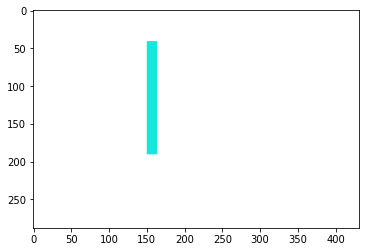

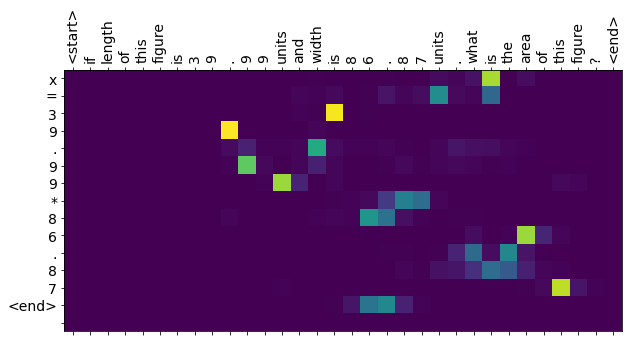

In [ ]:
translate(sentence = 'If length of this figure is 39.99 units and width is 86.87 units. What is the area of this figure?',figure="plotrectangles0.png")

Score:  1
Input: <start> if length of this figure is 3 9 . 9 9 units and area is 1 2 2 . 8 7 units . what is the width of this figure ? <end>
Fact used from memory network:  ['Area of Rectangle = length * width', 0.19802950859533489]

Predicted translation: x = 3 9 . 9 9 <end> 



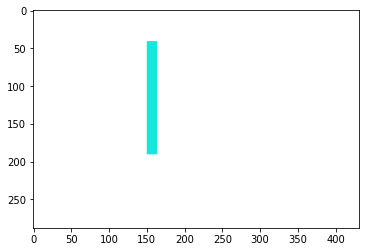

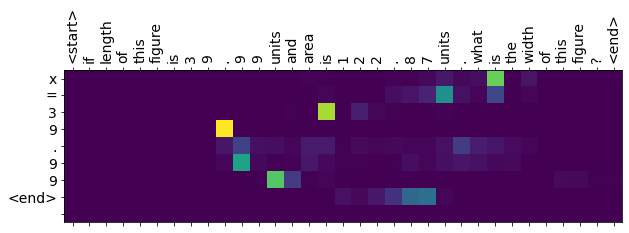

In [ ]:
translate(sentence = 'If length of this figure is 39.99 units and area is 122.87 units. What is the width of this figure?',figure="plotrectangles0.png")

Score:  1
Input: <start> if coordinates of this figure are ( 9 . 7 7 , 3 . 6 9 ) and ( 1 . 9 7 , 4 . 7 1 ) . what is the slope of this figure ? <end>
Fact used from memory network:  ['slope of line = (y2-y1)/(x2-x1)', 0.25]

Predicted translation: x = ( 4 . 7 1 - 3 . 6 9 ) / ( 1 . 9 7 - 9 . 7 7 ) <end> 



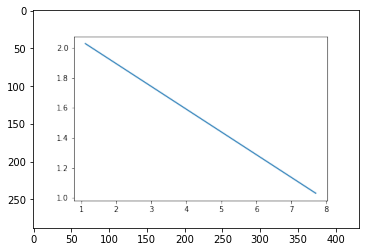

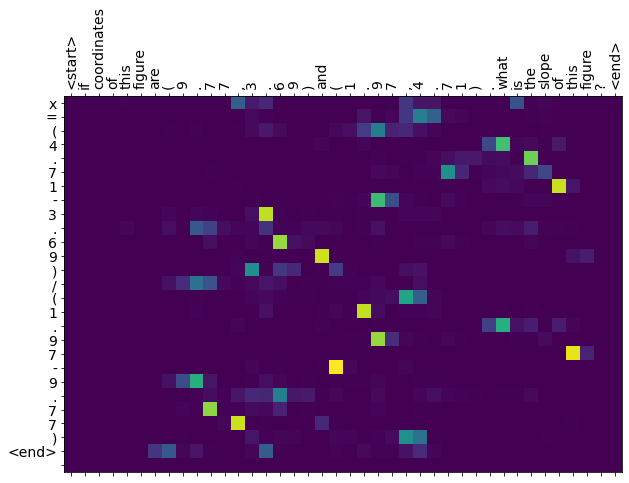

In [ ]:
a = translate(sentence='If coordinates of this figure are (9.77 , 3.69) and (1.97 , 4.71). What is the slope of this figure?',figure="plotlines0.png")

Score:  1
Input: <start> if area of this figure is 0 . 4 5 sq units . calculate the radius of this figure ? <end>
Fact used from memory network:  ['Area of Circle = pi * radius * radius', 0.10540925533894598]

Predicted translation: x = m a t h . s q r t ( 0 . 4 5 / 3 . 1 4 ) <end> 



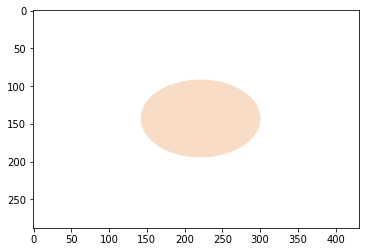

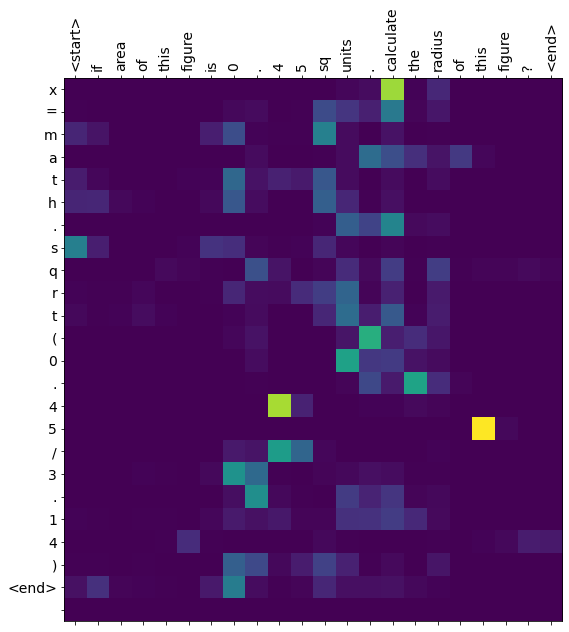

In [ ]:
a = translate(sentence='If area of this figure is 0.45 sq units. Calculate the radius of this figure?',figure="plotcircles3.png")

Score:  1
Input: <start> the perimeter of the yard shown in figure is 5 . 9 2 sq feet . find the side length of this yard . <end>
Fact used from memory network:  ['Area of Square = side * side', 0.10846522890932808]

Predicted translation: x = 5 . 9 2 / 4 <end> 



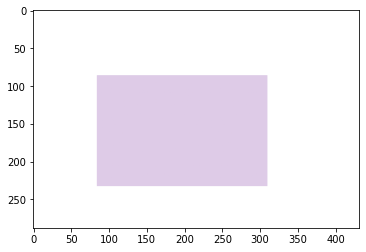

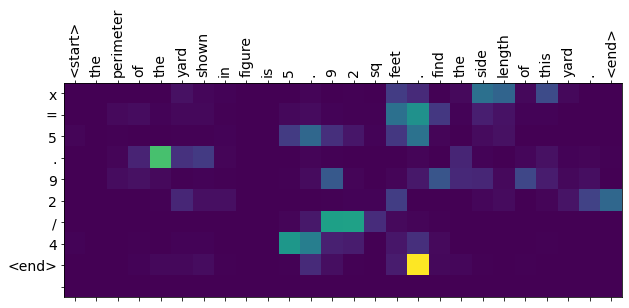

In [ ]:
a = translate(sentence='The perimeter of the yard shown in figure is 5.92 sq feet. Find the side length of this yard.',figure="plotsquareside0.png")

Score:  1
Input: <start> length of a side of a of this figure is 2 . 6 units . measure the area of this figure ? <end>
Fact used from memory network:  ['Area of Square = side * side', 0.11952286093343936]

Predicted translation: x = 2 . 6 * 2 . 6 <end> 



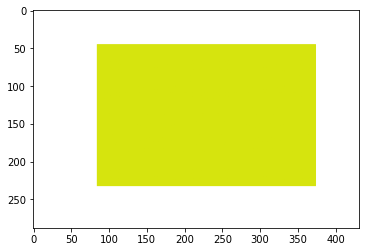

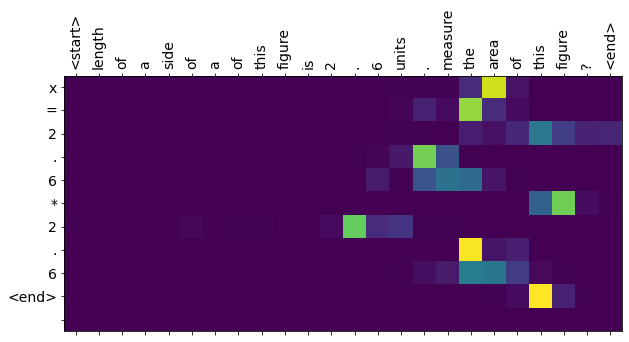

In [ ]:
a = translate(sentence='Length of a side of a of this figure is 2.6 units. Measure the area of this figure?',figure="plotsquareside1.png")

Score:  1
Input: <start> if circumference of this figure is 0 . 6 4 sq units . calculate the diameter of this figure ? <end>
Fact used from memory network:  ['Perimeter of Square = 4 * side', 0.10540925533894598]

Predicted translation: x = 0 . 6 4 / 3 . 1 4 <end> 



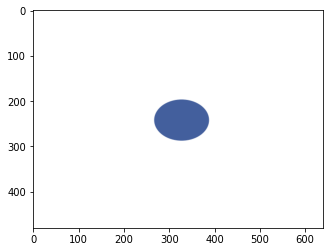

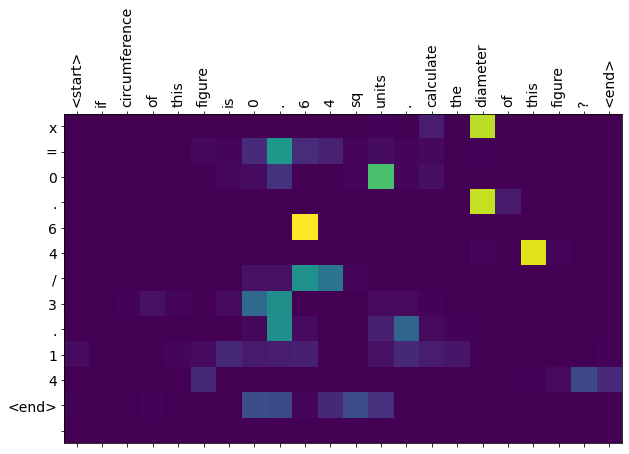

In [ ]:
a = translate(sentence='If circumference of this figure is 0.64 sq units. Calculate the diameter of this figure?',figure="plotcircles0.png")

Score:  1
Input: <start> if the three sides of this figure are [ ( 2 . 1 5 , 5 . 8 8 ) , ( 7 . 1 , 4 . 1 7 ) , ( 3 . 7 1 , 5 . 7 2 ) ] . what is the minimum height of this figure to the base formed by the coordinates ( 2 . 1 5 , 5 . 8 8 ) and ( 7 . 1 , 4 . 1 7 ) ? <end>
Fact used from memory network:  ['Minimum height of Triangle = (2*area)/base', 0.20801257358446093]

Predicted translation: x = ( 2 * 0 . 9 2 ) / 3 . 3 9 <end> 



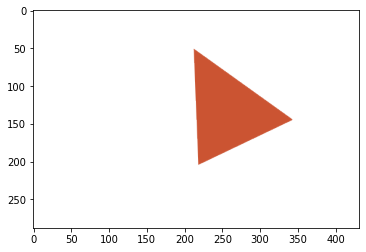

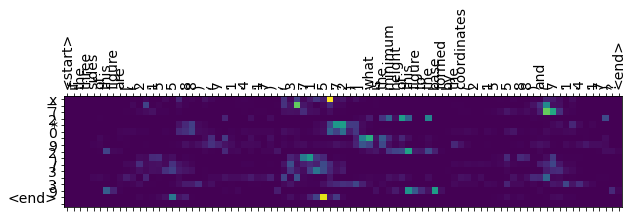

In [ ]:
a = translate(sentence='If the three sides of this figure are [(2.15, 5.88), (7.1, 4.17), (3.71, 5.72)]. What is the minimum height of this figure to the base formed by the coordinates (2.15, 5.88) and (7.1, 4.17)?',figure="plottrianglear0.png")

In [ ]:
a = translate(sentence='If length and area of this figure are 13.25 units and 46.87 units respectively. What will be the width of this figure?',figure="plotcircles1.png")

Score:  0
Input: <start> if length and area of this figure are 1 3 . 2 5 units and 4 6 . 8 7 units respectively . what will be the width of this figure ? <end>
Input figure is not valid


Score:  1
Input: <start> if radius of this figure is 0 . 2 1 units . what is the circumference of this figure ? <end>
Fact used from memory network:  ['Area of Circle = pi * radius * radius', 0.11322770341445956]

Predicted translation: x = 2 * 3 . 1 4 * 0 . 2 1 <end> 



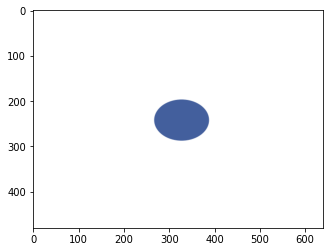

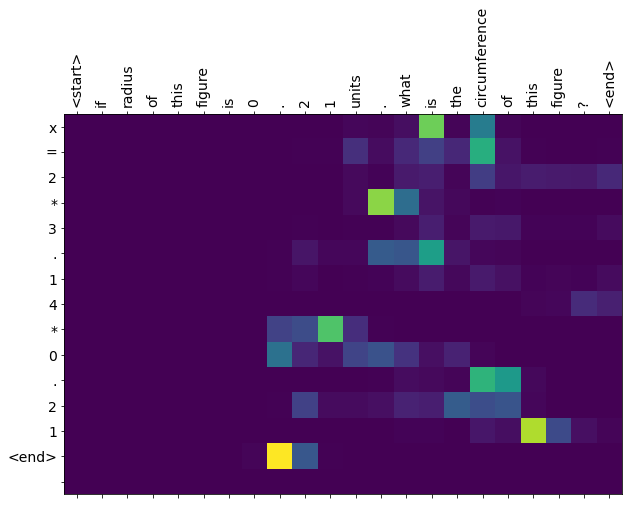

In [ ]:
a = translate(sentence='If radius of this figure is 0.21 units. What is the circumference of this figure?',figure="plotcircles0.png")

Score:  1
Input: <start> if radius of this figure is 0 . 5 6 units . what is the area of this figure ? <end>
Fact used from memory network:  ['Area of Circle = pi * radius * radius', 0.11322770341445956]

Predicted translation: x = 3 . 1 4 * 0 . 5 6 * 0 . 5 6 <end> 



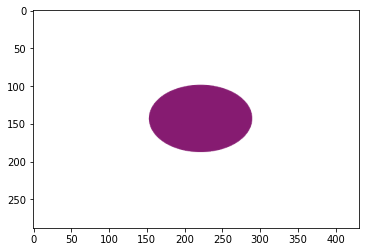

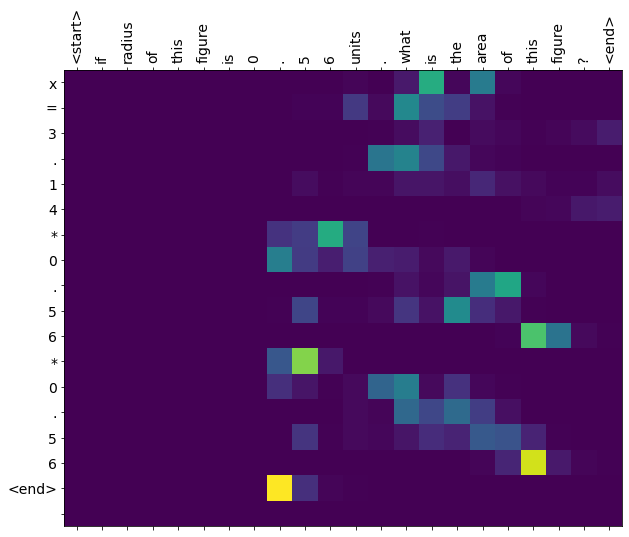

In [ ]:
a = translate(sentence='If radius of this figure is 0.56 units. What is the area of this figure?',figure="plotcircles1.png")